In [ ]:
                                            #Logistic Regression
# load data and inspect
import pandas as pd 
#load and inspect data
df = pd.read_csv("Social_Network_Ads.csv")
df.head()
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')

In [ ]:
#drop useless identifier
df = df.drop(columns=['User ID'])
df['Gender'] = df["Gender"].map({"Male": 1, "Female": 0})

print (df.dtypes)
df.head()

Gender             int64
Age                int64
EstimatedSalary    int64
Purchased          int64
dtype: object


,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [ ]:
#features/labels + train/test split
from sklearn.model_selection import train_test_split

X = df[['Gender', 'Age', 'EstimatedSalary']]
y = df['Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()



((320, 3),
 (80, 3),
 Purchased
 0    206
 1    114
 Name: count, dtype: int64,
 Purchased
 0    51
 1    29
 Name: count, dtype: int64)

In [ ]:
#Evaluate model
#1) Imports
from sklearn.pipeline import make_pipeline                        #builds a sequence of steps
from sklearn.preprocessing import StandardScaler                  #scales numeric feature
from sklearn.linear_model import LogisticRegression               #simple classification model
from sklearn.metrics import accuracy_score, classification_report #ways to measure performance
# 2) Build a pipeline: [scale] -> [logistic regression]
pipe = make_pipeline(
    StandardScaler(),                                   #scale features
    LogisticRegression(random_state=42, max_iter=1000)  # the model
)
# 3) Train (fit) the model on the training set
pipe.fit(X_train, y_train)

# 4) Use the trained model to predict on the unseen (20%) test set
y_predict = pipe.predict(X_test)

# 5) Evaluate: how many right?
print ("Accuracy:", accuracy_score(y_test, y_predict))
print (classification_report(y_test, y_predict, digits=3))

Accuracy: 0.8
              precision    recall  f1-score   support

           0      0.797     0.922     0.855        51
           1      0.810     0.586     0.680        29

    accuracy                          0.800        80
   macro avg      0.803     0.754     0.767        80
weighted avg      0.801     0.800     0.791        80



Accuracy: 0.8
AUC: 0.9080459770114943
              precision    recall  f1-score   support

           0      0.797     0.922     0.855        51
           1      0.810     0.586     0.680        29

    accuracy                          0.800        80
   macro avg      0.803     0.754     0.767        80
weighted avg      0.801     0.800     0.791        80



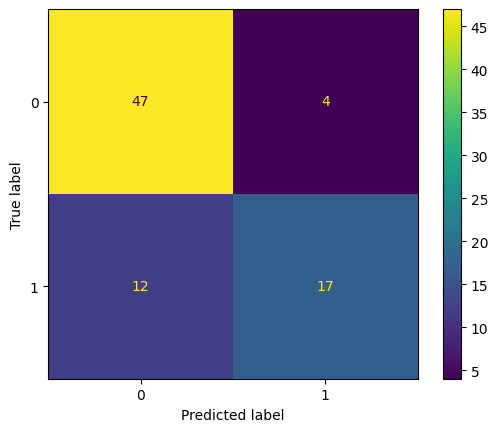

In [ ]:
# Model performance
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, classification_report
import matplotlib.pyplot as plt

#1) Predict class labels (0/1) and probabilities
y_pred = pipe.predict(X_test)                   #class predictions
y_proba = pipe.predict_proba(X_test)[:,1]       # probability of class "1"

#2) Basic scores
print ("Accuracy:", (y_pred == y_test).mean())
print ("AUC:", roc_auc_score(y_test, y_proba))
print (classification_report(y_test, y_pred, digits = 3))

#3) Confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

In [ ]:
# tune threshold
from sklearn.metrics import precision_score, recall_score, f1_score

# probabilities for buyer (class 1)
y_pred = pipe.predict_proba(X_test)[:,1]

def predict_with_threshold(proba, t):
    return (proba >= t).astype(int)

#try new thresold
for t in [0.3, 0.5, 0.7]:
    y_pred_thres = predict_with_threshold(y_proba, t)
    prec = precision_score(y_test, y_pred_thres)
    rec = recall_score(y_test, y_pred_thres)
    f1 = f1_score(y_test, y_pred_thres)
    print (f"threshold={t:.1f} precision={prec:.3f} recall={rec:.3f} f1={f1:.3f}")
    #result
# threshold=0.3 precision=0.650 recall=0.897 f1=0.754
# threshold=0.5 precision=0.810 recall=0.586 f1=0.680
# threshold=0.7 precision=0.875 recall=0.483 f1=0.622
#=> threshold = 0.3: best f1

threshold=0.3 precision=0.650 recall=0.897 f1=0.754
threshold=0.5 precision=0.810 recall=0.586 f1=0.680
threshold=0.7 precision=0.875 recall=0.483 f1=0.622


In [ ]:
#final report
 
#a) import
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib as plt

#base at 0.5
y_pred_05 = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#chosen threshold
t= 0.3
y_pred_thres_03 = (y_proba >= t).astype(int)

report = pd.DataFrame({
    "metric": ["accuracy:o,5", "precision:0.5", "recall:0.5", "f1:0.5","auc",
    f"precision:{t}", f"recall:{t}", f"f1:{t}"],
    "value": [
        accuracy_score(y_test, y_pred_05),
        precision_score(y_test, y_pred_05),
        recall_score(y_test, y_pred_05),
        f1_score(y_test, y_pred_05),
        roc_auc_score(y_test, y_proba),
        precision_score(y_test, y_pred_thres_03),
        recall_score(y_test, y_pred_thres_03),
        f1_score(y_test, y_pred_thres_03)
    ]
})

cm = confusion_matrix(y_test, y_pred_thres_03)

report.round(3), cm

(          metric  value
 0   accuracy:o,5  0.800
 1  precision:0.5  0.810
 2     recall:0.5  0.586
 3         f1:0.5  0.680
 4            auc  0.908
 5  precision:0.3  0.650
 6     recall:0.3  0.897
 7         f1:0.3  0.754,
 array([[37, 14],
        [ 3, 26]]))

In [25]:
                                                    #Decision Tree
#1) Import models and metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

#2) Create a tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)

#3) Fit training data
tree.fit(X_train, y_train)

#4) Predict unseen data
tree_pred = tree.predict(X_test)
tree_proba = tree.predict_proba(X_test)[:, 1]

#5) Evaluate
print("Accuracy:", accuracy_score(y_test, tree_pred))
print("AUC     :", roc_auc_score(y_test, tree_proba))
print(classification_report(y_test, tree_pred, digits=3))

Accuracy: 0.8625
AUC     : 0.9350912778904664
              precision    recall  f1-score   support

           0      0.900     0.882     0.891        51
           1      0.800     0.828     0.814        29

    accuracy                          0.863        80
   macro avg      0.850     0.855     0.852        80
weighted avg      0.864     0.863     0.863        80

